## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read csv logs
rows = pd.read_csv('datalog_train_simple.csv')
angles = rows['angle'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  2600


In [3]:
# split
shuffle(samples, angles)
imgs_train, imgs_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [4]:
# constants
SIZE = 64
BATCH_SIZE = 64

EPOCHS = 10
LRATE = 0.0005
STEPDECAY = 0.3
DECAYFREQ = 10

In [5]:
# data preprocessing pipeline
def resize(img):
    return cv2.resize(img, (SIZE, SIZE))

def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def flip(img, angle):
    if random.randint(0, 1) == 0:
        return img, angle
    img = np.fliplr(img)
    angle = -angle
    return img, angle

def normalize(img):
    image = np.copy(img)
    image = image / 250. - 0.5
    return image

def random_shadow(img):
    if random.randint(0, 1) == 0:
        return img
    # set top x
    x_top = random.randint(0, img.shape[1])
    # set bottom x
    x_bot = random.randint(0, img.shape[1])
    if x_top >= img.shape[1] // 2:
        x_bot = random.randint(0, img.shape[1] // 2)
    if x_top > img.shape[1] // 2:
        x_bot = random.randint(img.shape[1] // 2, img.shape[1])
    # set corner x
    x3 = x4 = random.choice([0, img.shape[1]])
    # set y1, y2
    y1 = 0
    y2 = img.shape[0]
    # draw shadow
    overlay = np.copy(img)
    pts = np.array([[x_top, y1], [x3, y1], [x4, y2], [x_bot, y2]], np.int32)
    shadow = cv2.fillPoly(overlay, [pts], (0, 0, 0))
    alfa = random.uniform(0.2, 0.8)
    return cv2.addWeighted(shadow, alfa, img, 1 - alfa, 0)

In [6]:
# preprocess data
# training
train_imgs = []
train_angles = []
for i in range(len(imgs_train)):
    angle = angles_train[i] * (1 + random.uniform(-0.03, 0.03)) # add noise
    img = mpimg.imread(imgs_train[i])
    img = random_shift(img)
    img = random_shadow(img)
    img, angle = flip(img, angle)
    img = resize(img)
    img = normalize(img)
    train_imgs.append(img)
    train_angles.append(angle)

# validation
valid_imgs = []
valid_angles = []
for i in range(len(imgs_valid)):
    angle = angles_valid[i]
    img = mpimg.imread(imgs_valid[i])
    img = resize(img)
    img = normalize(img)
    valid_imgs.append(img)
    valid_angles.append(angle)

In [7]:
# tensorflow graph placeholders
x = tf.placeholder(tf.float32, (None, SIZE, SIZE, 3), name='x')
y = tf.placeholder(tf.float32, (None), name='y')

In [8]:
# network architecture
layer1_W = tf.get_variable('W1', shape=[5, 5, 3, 24], initializer=tf.contrib.keras.initializers.he_normal()) 
layer1_b = tf.get_variable('b1', shape=[24], initializer=tf.zeros_initializer())
layer1 = tf.nn.conv2d(x, layer1_W, strides=[1, 2, 2, 1], padding='VALID')
layer1 = tf.nn.bias_add(layer1, layer1_b, name='layer1')
layer1 = tf.nn.elu(layer1)

print("layer1: ", layer1.get_shape())

flatten = tf.contrib.layers.flatten(layer1)

print("flatten: ", flatten.get_shape())

layer2_W = tf.get_variable('W2', shape=[21600, 100], initializer=tf.contrib.keras.initializers.he_normal()) 
layer2_b = tf.get_variable('b2', shape=[100], initializer=tf.zeros_initializer())
layer2 = tf.add(tf.matmul(flatten, layer2_W), layer2_b, name='layer2')
layer2 = tf.nn.elu(layer2)

print("layer2: ", layer2.get_shape())

layer3_W = tf.get_variable('W3', shape=[100, 1], initializer=tf.contrib.keras.initializers.he_normal()) 
layer3_b = tf.get_variable('b3', shape=[1], initializer=tf.zeros_initializer())
logits = tf.add(tf.matmul(layer2, layer3_W), layer3_b, name='output')

print("logits: ", logits.get_shape())

layer1:  (?, 30, 30, 24)
flatten:  (?, 21600)
layer2:  (?, 100)
logits:  (?, 1)


In [9]:
# training pipeline

# loss = tf.reduce_mean(tf.squared_difference(logits, y))
loss = tf.losses.mean_squared_error(labels=y, predictions=logits)
# loss = tf.reduce_mean(tf.pow((logits - y),2))

optimizer = tf.train.AdamOptimizer(learning_rate=LRATE)
training_operation = optimizer.minimize(loss)

# model evaluation pipeline
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    shuffle(X_data, y_data)
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]        
        loss_value = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        total_loss += loss_value * len(batch_x)
    return total_loss / num_examples

In [10]:
# train model with learning rate step decay
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plot_learning_curves = []
    num_examples = len(train_imgs)
    
    print("Training...")
    print()
    print("learning rate: ", LRATE)
    
    for epoch in range(EPOCHS):
        shuffle(train_imgs, train_angles)
        
        if (epoch + 1) != EPOCHS and (epoch + 1) % DECAYFREQ == 0:
            LRATE *= STEPDECAY
            print("New learning rate: ", LRATE)
            print()
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_imgs[offset:end], train_angles[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        training_loss = evaluate(train_imgs, train_angles)
        validation_loss = evaluate(valid_imgs, valid_angles)
        plot_learning_curves.append((training_loss, validation_loss))
        
        print("EPOCH {} ...".format(epoch + 1))
        print("Train loss = {:.3f}".format(training_loss))
        print("Valid loss = {:.3f}".format(validation_loss))
        print()       
    
    plot_later = pd.DataFrame(plot_learning_curves, columns=['train_loss', 'valid_loss'])
    # plot_later.to_csv('tmp.csv', index=False)
    
    saver.save(sess, './tf_model/model_tf_simple')
    print("Model saved")

Training...

learning rate:  0.0005
EPOCH 1 ...
Train loss = 34.716
Valid loss = 34.867

EPOCH 2 ...
Train loss = 35.741
Valid loss = 36.041

EPOCH 3 ...
Train loss = 34.953
Valid loss = 35.183

EPOCH 4 ...
Train loss = 35.180
Valid loss = 35.426

EPOCH 5 ...
Train loss = 34.844
Valid loss = 35.070

EPOCH 6 ...
Train loss = 34.671
Valid loss = 34.887

EPOCH 7 ...
Train loss = 34.596
Valid loss = 34.818

EPOCH 8 ...
Train loss = 34.564
Valid loss = 34.794

EPOCH 9 ...
Train loss = 34.550
Valid loss = 34.787

EPOCH 10 ...
Train loss = 34.543
Valid loss = 34.786

Model saved


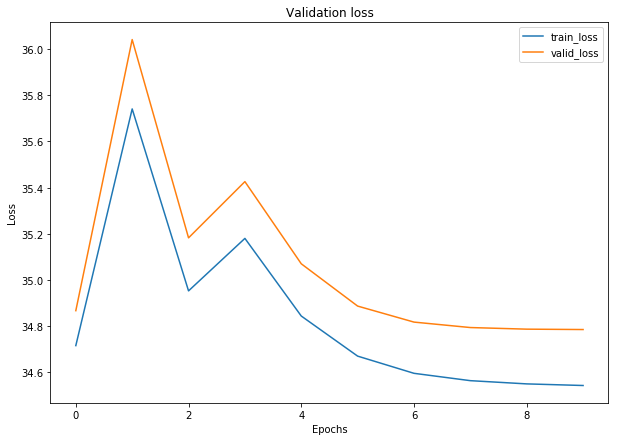

In [11]:
# plot loss
# plot_l1 = pd.read_csv('tmp.csv')
ax = plot_later.plot(title='Validation loss', figsize=(10, 7))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

## Evaluate model

In [12]:
# read csv logs
rows_test = pd.read_csv('datalog_test_simple.csv')
angles_test = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  500


In [13]:
# load test data
img_test = []
ang_test = []

for i in range(len(samples_test)-1):
    angle = angles_test[i]
    img = mpimg.imread(samples_test[i])
    img = resize(img)
    img = normalize(img)
    img_test.append(img)
    ang_test.append(angle)

test_imgs = np.array(img_test)
test_angles = np.array(ang_test)

In [14]:
# evaluate model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    test_loss = evaluate(test_imgs, test_angles)
    print("Average error: ±{:.2f} degrees".format(np.sqrt(test_loss)))

INFO:tensorflow:Restoring parameters from ./tf_model/model_tf_simple
Average error: ±5.84 degrees


Actual angle:  7


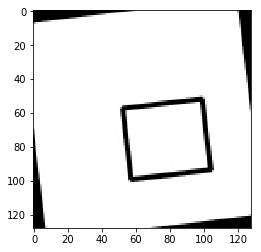

In [15]:
# example: one test image that we want to correct
random.seed(12)
random_index = random.randint(0,len(samples_test)-1)
angle = angles_test[random_index]
img = mpimg.imread(samples_test[random_index])
plt.imshow(img)
print("Actual angle: ", angle)

In [16]:
# predict angle
image = np.copy(img)
image = resize(image)
image = normalize(image)
image_array = np.asarray(image)
h, w, ch = image_array.shape
img_tf = np.reshape(image_array, [1, h, w, ch])
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    test_pred = sess.run(logits, feed_dict={x: img_tf})
    ang = test_pred[0][0]
    print("Predicted angle:{:.2f}".format(ang))

INFO:tensorflow:Restoring parameters from ./tf_model/model_tf_simple
Predicted angle:-0.12


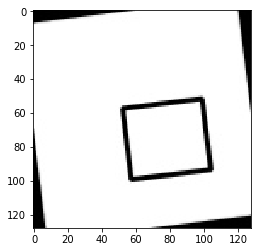

In [17]:
# angle correction
height, width, ch = img.shape
sh = (width, height)
center = (width // 2, height // 2)
M = cv2.getRotationMatrix2D(center, -ang, 1.0)
result = cv2.warpAffine(img, M, sh)
plt.imshow(result)
plt.show()